In [1]:
import numpy as np
from numpy import sqrt
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import argrelmax, savgol_filter
from scipy.interpolate import UnivariateSpline

In [2]:
def gaussian_absorption(x, amp, center, sigma, offset):
    return offset - amp * np.exp(-(x - center)**2 / (2 * sigma**2))

def voigt_absorption(x, amp, center, sigma, gamma, offset):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    voigt_prof = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    voigt_norm = voigt_prof / np.max(voigt_prof)
    return offset - amp * voigt_norm

In [3]:
def normalize_continuum(wavelength, flux, flux_error=None, poly_order=3, exclude_regions=None, plot=False):
    mask = np.ones_like(wavelength, dtype=bool)
    if exclude_regions is not None:
        for region in exclude_regions:
            mask &= ~((wavelength > region[0]) & (wavelength < region[1]))

    poly_coeffs = np.polyfit(wavelength[mask], flux[mask], deg=poly_order)
    continuum = np.polyval(poly_coeffs, wavelength)
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    if plot:
        plt.figure()
        plt.plot(wavelength, flux, label="Original Flux")
        plt.plot(wavelength, continuum, label="Fitted Continuum", linestyle="--")
        if exclude_regions is not None:
            for region in exclude_regions:
                plt.axvspan(region[0], region[1], color='red', alpha=0.2)
        plt.legend()
        plt.title("Continuum Normalization")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.tight_layout()
        plt.show()

    return norm_flux, norm_flux_error, continuum

def iterative_polyfit(wavelength, flux, flux_error=None, degree=3, sigma=2, max_iter=5, plot=False):
    mask = np.ones_like(wavelength, dtype=bool)
    for _ in range(max_iter):
        coeffs = np.polyfit(wavelength[mask], flux[mask], degree)
        model = np.polyval(coeffs, wavelength)
        residuals = flux - model
        std = np.std(residuals[mask])
        mask &= np.abs(residuals) < sigma * std

    continuum = np.polyval(coeffs, wavelength)
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    if plot:
        plt.figure()
        plt.plot(wavelength, flux, label="Original Flux")
        plt.plot(wavelength, continuum, label="Fitted Continuum", linestyle="--")
        plt.legend()
        plt.title("Continuum Normalization")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.tight_layout()
        plt.show()
    
    return norm_flux, norm_flux_error, continuum

In [4]:
def fit_centroid(wavelength, flux, flux_error=None, lambda_0=None, w1=None, w2=None, line_name=None, plot=False):
    # Isolate the region of interest for normalization
    local_mask = (wavelength > w1) & (wavelength < w2)
    wavelength_local = wavelength[local_mask]
    flux_local = flux[local_mask]
    flux_error_local = flux_error[local_mask] if flux_error is not None else None

    # Normalize the flux ONLY within the local region
    # exclude_regions is set to None here because normalization is already localized.
    # If there are specific features to ignore *within* the w1-w2 range, I could define a `local_exclude_regions` and pass it here.
    # Change this line to use iterative_polyfit or normalize_continuum
    norm_flux_local, norm_flux_error_local, continuum_local = iterative_polyfit(
        wavelength_local, flux_local, flux_error=flux_error_local,
        degree=1, # You might need to adjust the degree based on your local continuum shape
        sigma=1,   # Adjust sigma for outlier rejection
        max_iter=10,
        plot=should_plot
    )
    offset_region_local = ((wavelength_local > w1) & (wavelength_local < (w1 + 15))) | ((wavelength_local > (w2 - 15)) & (wavelength_local < w2))
    
    # Filter out any non-finite values from the region before calculating median
    # (Though usually not an issue with flux, good practice)
    continuum_values_for_check = norm_flux_local[offset_region_local]
    continuum_values_for_check = continuum_values_for_check[np.isfinite(continuum_values_for_check)]

    if len(continuum_values_for_check) > 0:
        actual_median_continuum = np.median(continuum_values_for_check)
        print(f"Median of normalized flux in continuum regions: {actual_median_continuum:.4f}")
    else:
        print("Warning: No valid continuum points found in offset_region_local for median check.")

    # Check the offset_guess that will be used in the fit
    offset_guess = np.median(norm_flux_local[offset_region_local])
    print(f"Offset guess (p0[4]) for Voigt fit: {offset_guess:.4f}")
    
    # Use the locally normalized data for fitting
    x = wavelength_local
    y = norm_flux_local
    yerr = norm_flux_error_local if norm_flux_error_local is not None else None

    # Smooth to estimate approximate line center
    y_smoothed = gaussian_filter1d(y, sigma=2)
    center_guess = x[np.argmin(y_smoothed)]

    # Initial guess for Voigt
    gamma_guess = 35.0
    # Adjust offset_region to use the local wavelength array
    offset_region_local = ((wavelength_local > w1) & (wavelength_local < (w1 + 15))) | ((wavelength_local > (w2 - 15)) & (wavelength_local < w2))
    offset_guess = np.median(norm_flux_local[offset_region_local])
    amp_guess = offset_guess - np.min(y)
    amp_guess = np.clip(offset_guess - np.min(y), 0.01, 3.0)
    sigma_guess = 20.0

    p0 = [amp_guess, center_guess, sigma_guess, gamma_guess, offset_guess]
    lower = [
        0.0,              # amp: must be positive
        center_guess - 5.0, # center: expanded range
        1.0,              # sigma: allow smaller Gaussian widths
        5.0,              # gamma: allow smaller Lorentzian widths
        offset_guess - 0.1 # offset: keep relatively tight around the normalized continuum
    ]
    upper = [
        3.0,              # amp: max amplitude
        center_guess + 5.0, # center: expanded range
        50.0,             # sigma: allow larger Gaussian widths
        100.0,            # gamma: allow much larger Lorentzian widths (for Stark broadening)
        offset_guess + 0.1 # offset: keep relatively tight around the normalized continuum
    ]
    yerr_mod = yerr
    #yerr_mod = yerr.copy() if yerr is not None else None
    #if yerr_mod is not None:
        #core = (x > center_guess - 1.0) & (x < center_guess + 1.0)
        #yerr_mod[core] *= 1.1

    try:
        popt, pcov = curve_fit(voigt_absorption, x, y, p0=p0, bounds=(lower, upper), sigma=yerr_mod)
        center = popt[1]
        center_err = sqrt(pcov[1, 1]) if pcov is not None else np.nan
        print(f"Fit center = {center:.4f} ± {center_err:.4f} Å")
        velocity = 3e5 * (center - lambda_0) / lambda_0
        velocity_err = 3e5 * center_err / lambda_0

        # Diagnostic plot for the fit (now using locally normalized data)
        if plot:
            plt.figure(figsize=(10, 5))
            plt.errorbar(x, y, yerr=yerr, fmt='k.', ecolor='gray', capsize=2, label='Observed Spectrum')
            plt.plot(x, voigt_absorption(x, *popt), 'r-', label='Voigt Fit')
            plt.axvline(lambda_0, color='blue', linestyle=':', label=f'Reference Value: {lambda_0:.2f} Å')
            plt.axvline(popt[1], color='red', linestyle='--', label=f'Fit Center: {popt[1]:.2f} Å')
            plt.text(0.05, 0.05, f"Radial velocity estimate and error: {velocity:.2f}, {velocity_err:.2f}", fontsize=12, color='blue', horizontalalignment="left", verticalalignment="bottom", transform=plt.gca().transAxes)
            plt.title(f"{line_name} Voigt Fit (Locally Normalized)")
            plt.xlabel("Wavelength [Å]")
            plt.ylabel("Normalized Flux")
            plt.legend()
            plt.tight_layout()
            plt.show()
            residuals = y - voigt_absorption(x, *popt)

            # Residual vs. wavelength
            plt.figure(figsize=(10, 2))
            plt.axhline(0, color='gray', linestyle='--')
            plt.plot(x, residuals, 'k.', markersize=3)
            plt.title("Fit Residuals (Locally Normalized)")
            plt.xlabel("Wavelength [Å]")
            plt.ylabel("Flux Residual")
            plt.tight_layout()
            plt.show()

            # Histogram of residuals
            plt.figure()
            plt.hist(residuals, bins=30, color='gray', edgecolor='black')
            plt.title("Residual Distribution (Locally Normalized)")
            plt.xlabel("Residual")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()

        return center, center_err, velocity, velocity_err

    except Exception as e:
        print(f"Fit failed: {e}")
        return np.nan, np.nan, np.nan, np.nan

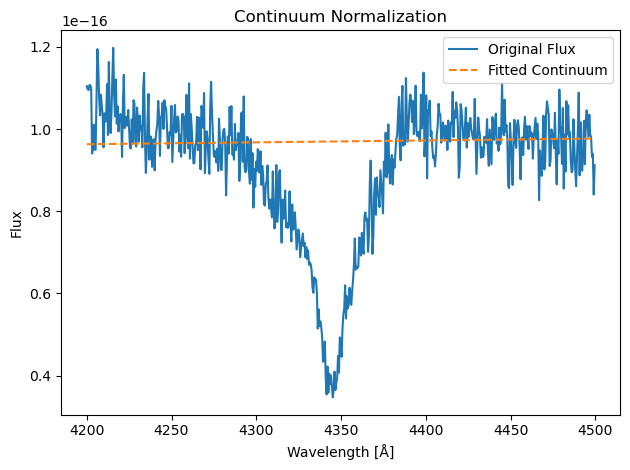

Median of normalized flux in continuum regions: 1.0412
Offset guess (p0[4]) for Voigt fit: 1.0412
Fit center = 4344.1964 ± 0.3023 Å


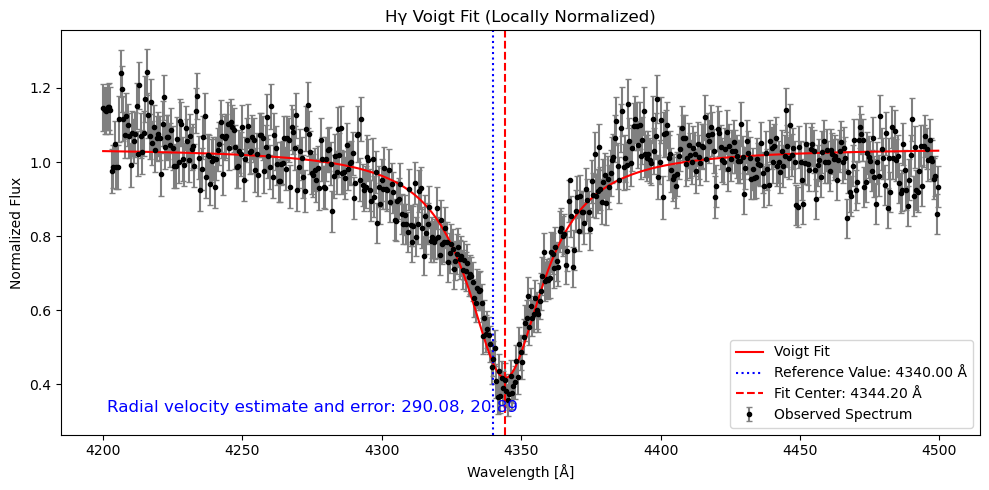

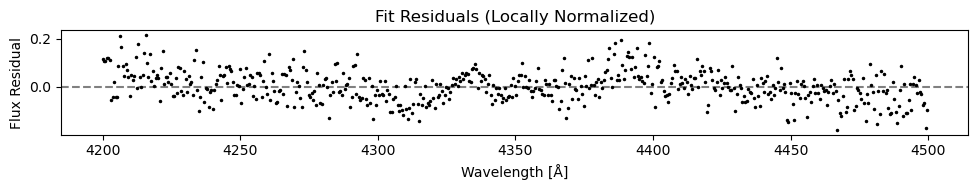

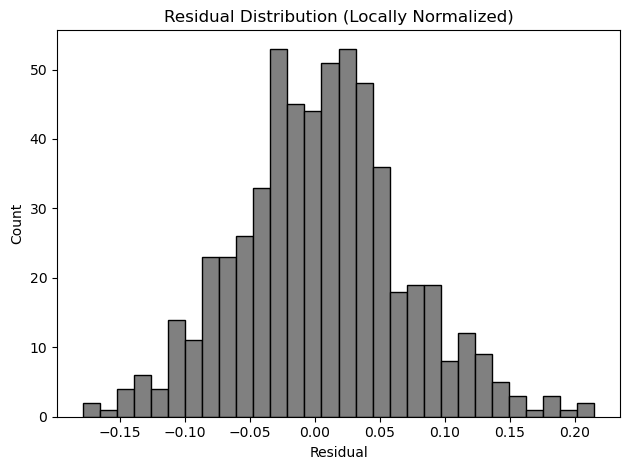

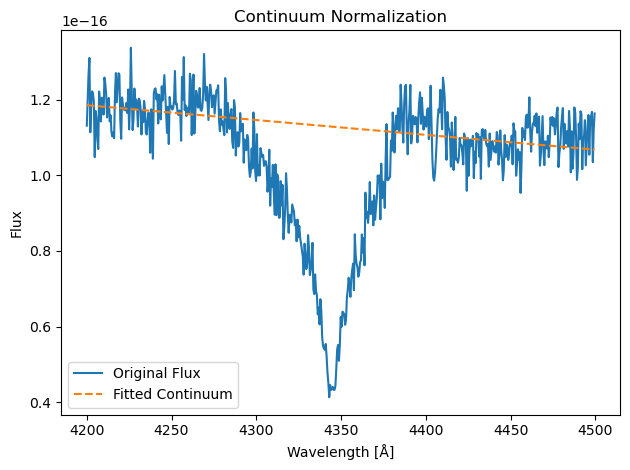

Median of normalized flux in continuum regions: 1.0157
Offset guess (p0[4]) for Voigt fit: 1.0157
Fit center = 4343.9445 ± 0.2649 Å


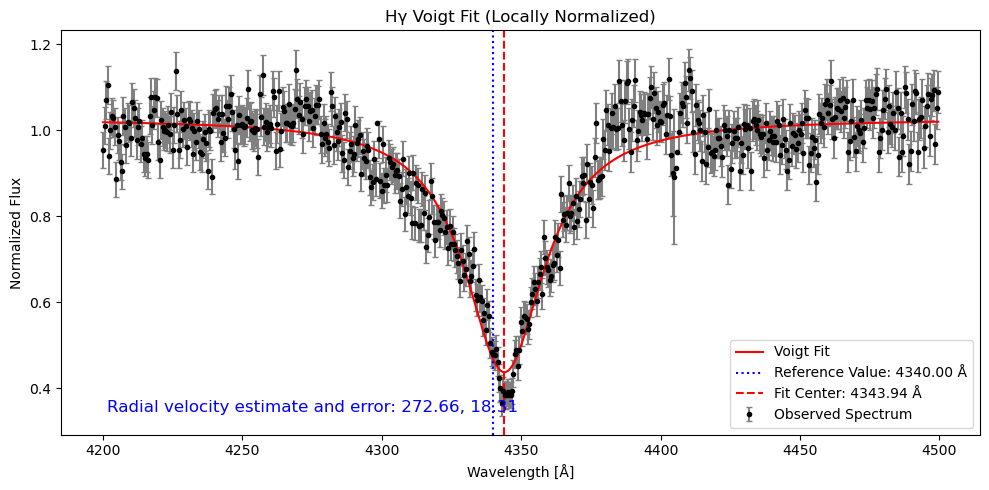

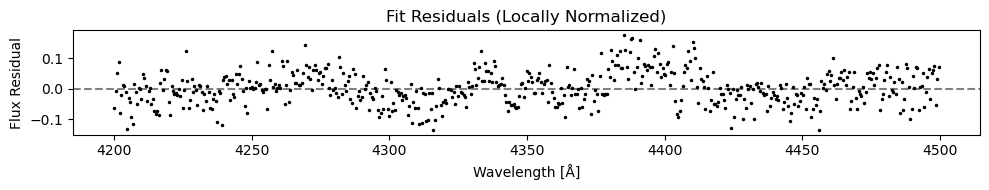

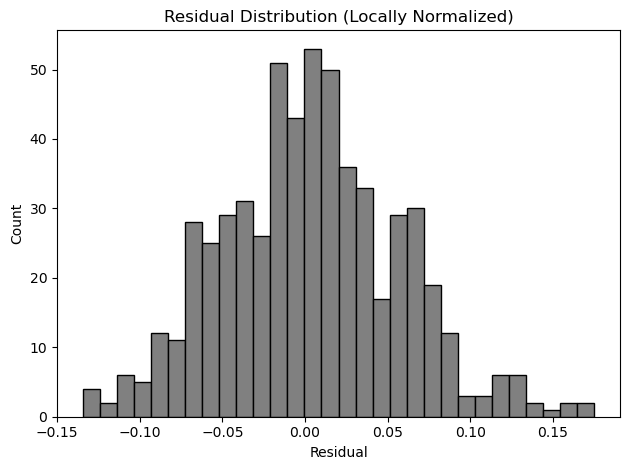

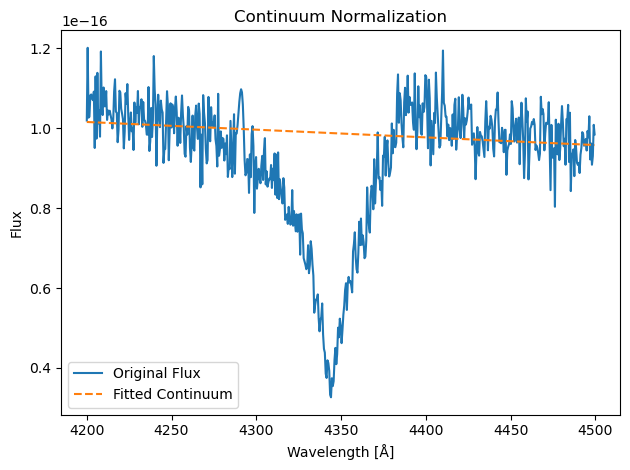

Median of normalized flux in continuum regions: 1.0133
Offset guess (p0[4]) for Voigt fit: 1.0133
Fit center = 4343.5154 ± 0.2864 Å


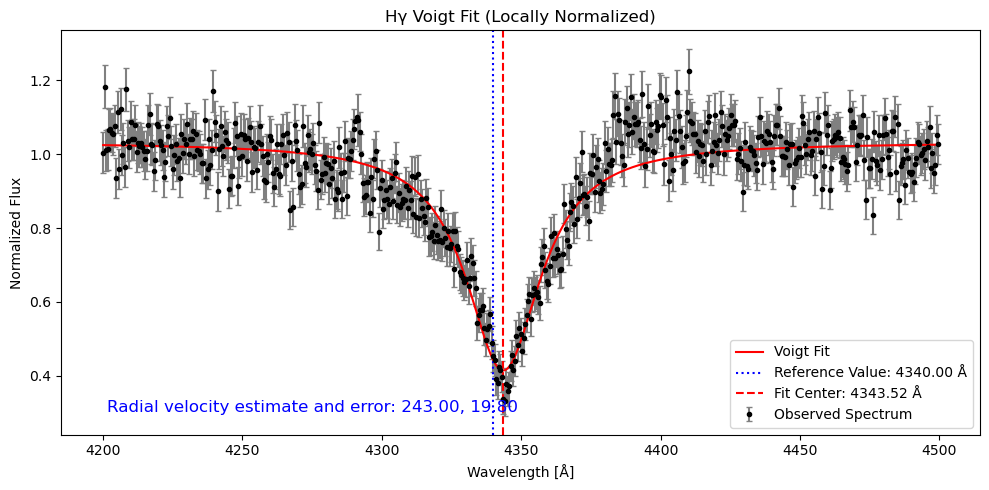

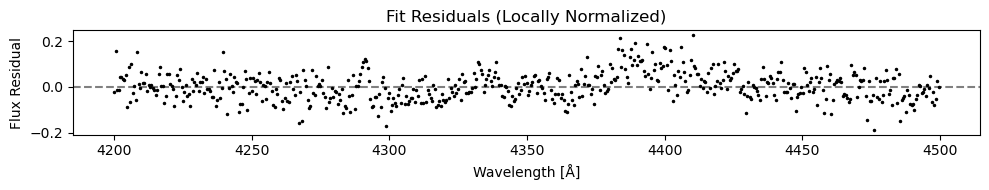

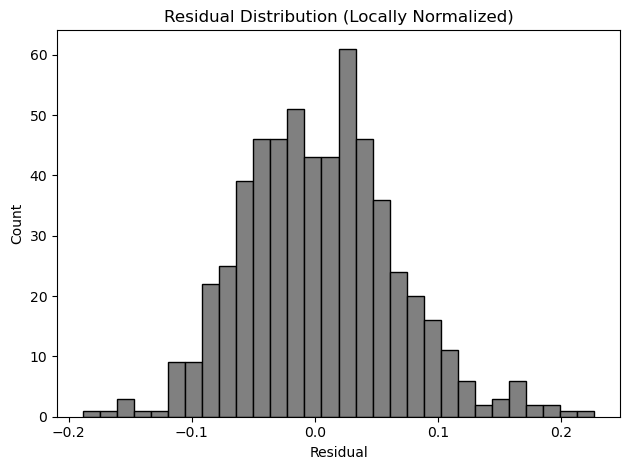

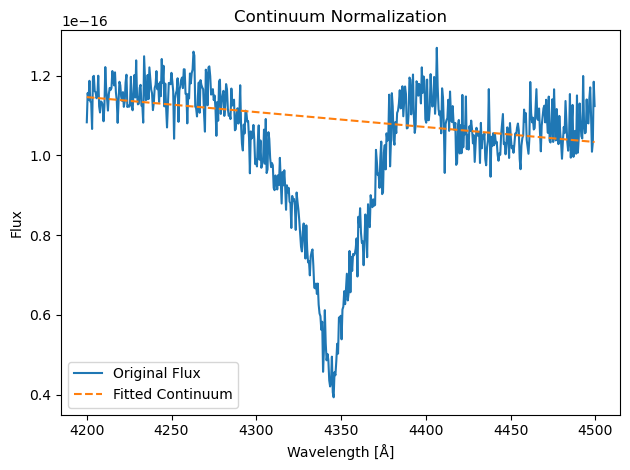

Median of normalized flux in continuum regions: 1.0145
Offset guess (p0[4]) for Voigt fit: 1.0145
Fit center = 4343.8112 ± 0.2506 Å


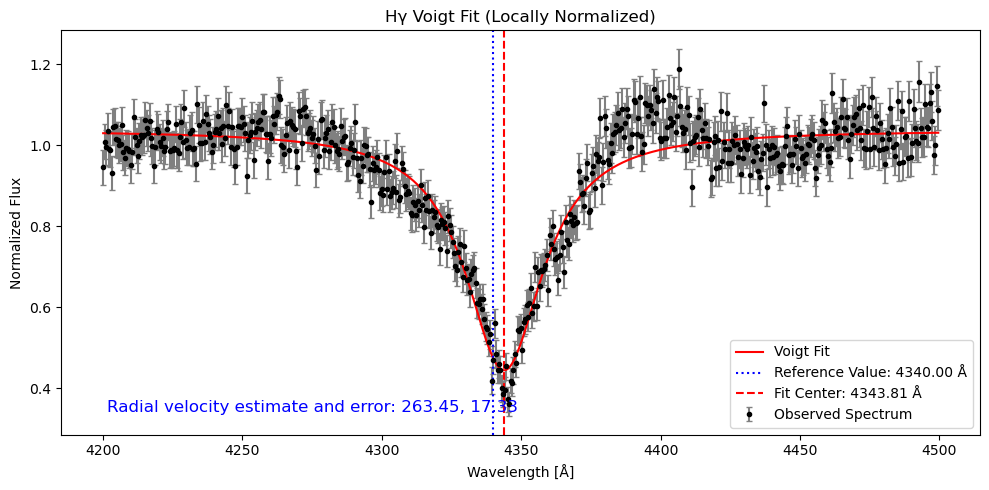

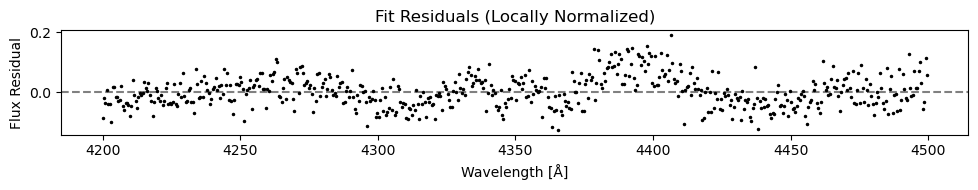

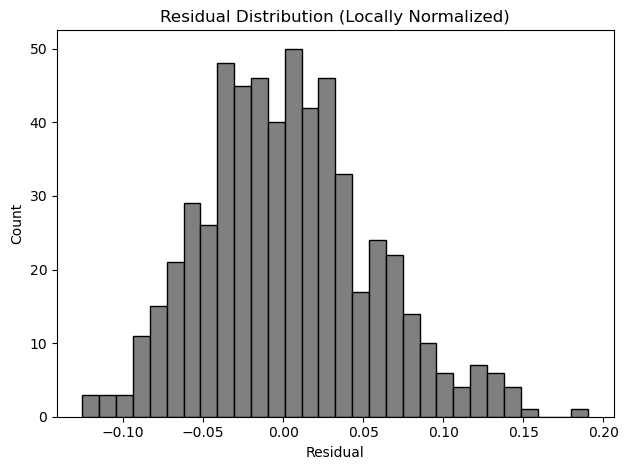

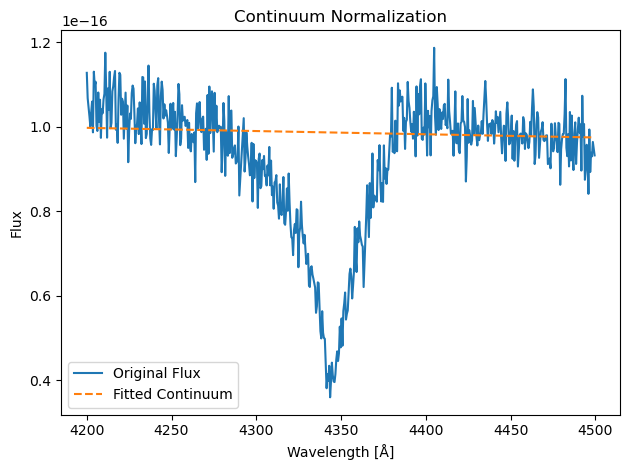

Median of normalized flux in continuum regions: 1.0150
Offset guess (p0[4]) for Voigt fit: 1.0150
Fit center = 4343.8438 ± 0.2912 Å


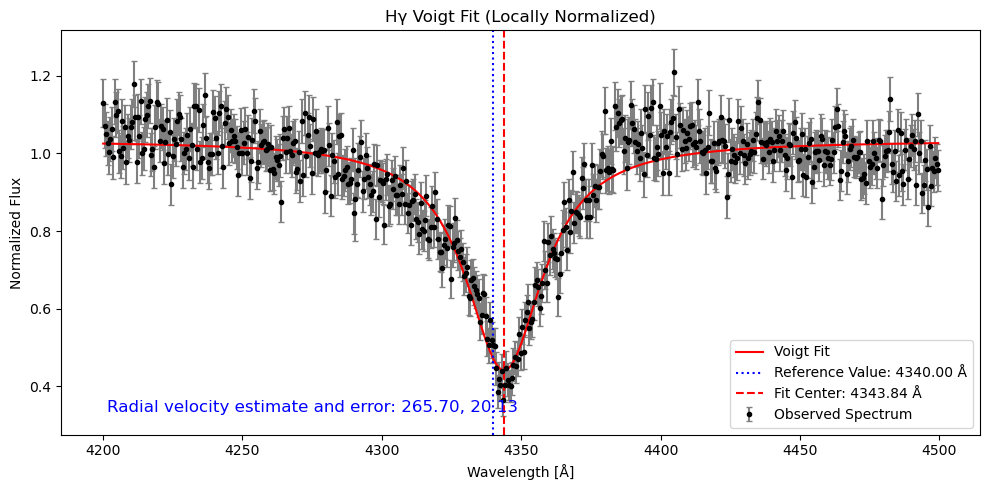

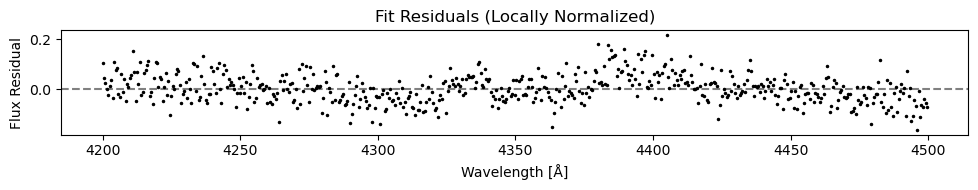

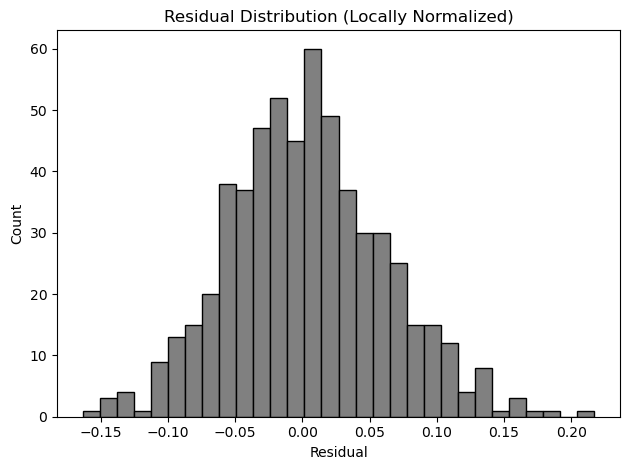

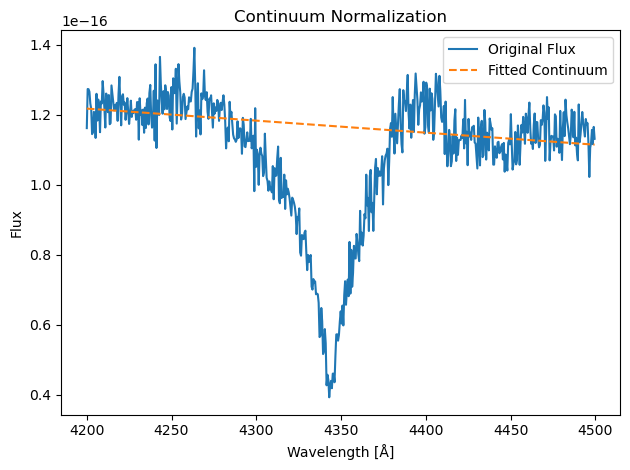

Median of normalized flux in continuum regions: 1.0151
Offset guess (p0[4]) for Voigt fit: 1.0151
Fit center = 4343.4916 ± 0.2351 Å


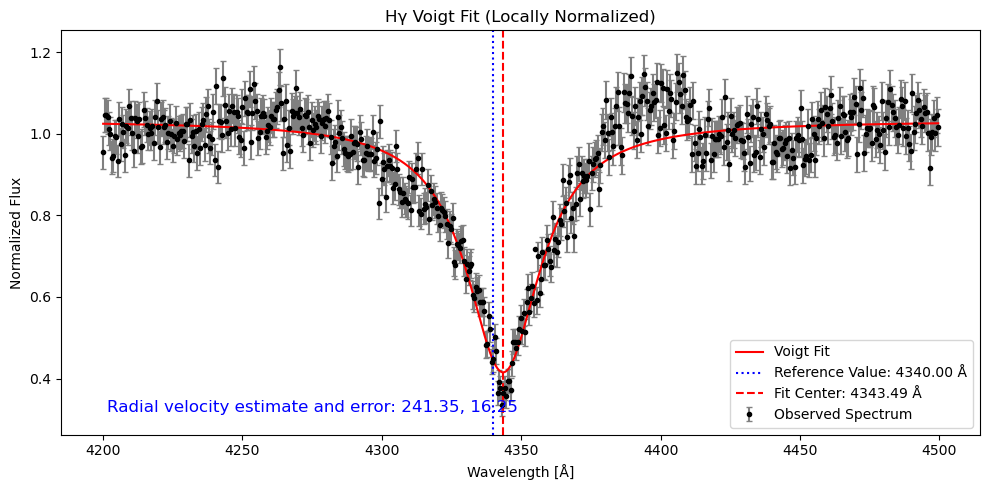

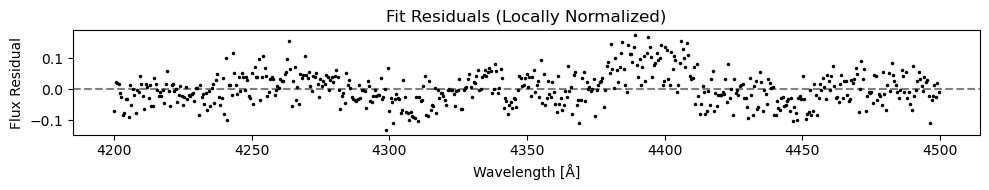

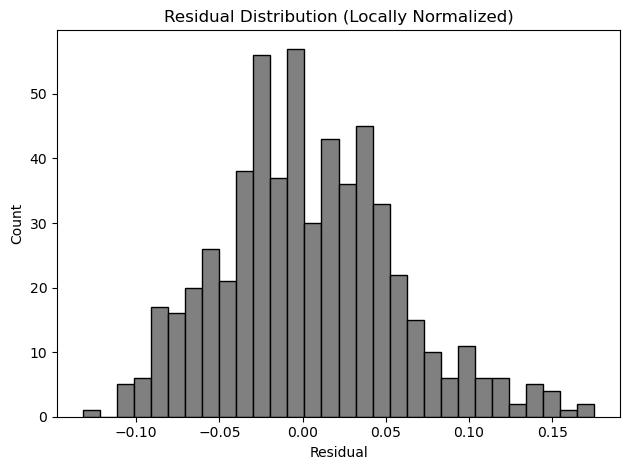

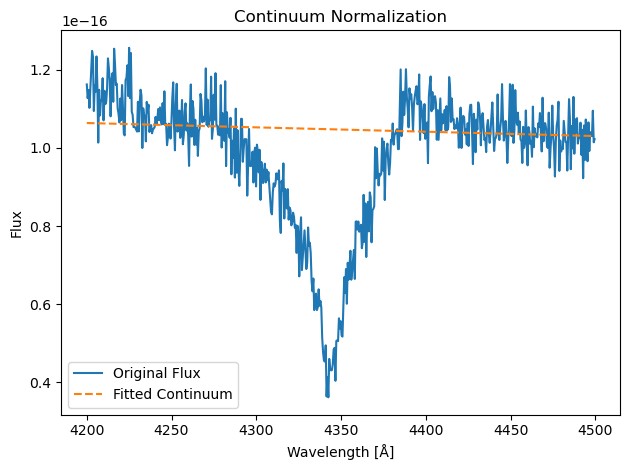

Median of normalized flux in continuum regions: 1.0365
Offset guess (p0[4]) for Voigt fit: 1.0365
Fit center = 4342.8869 ± 0.2929 Å


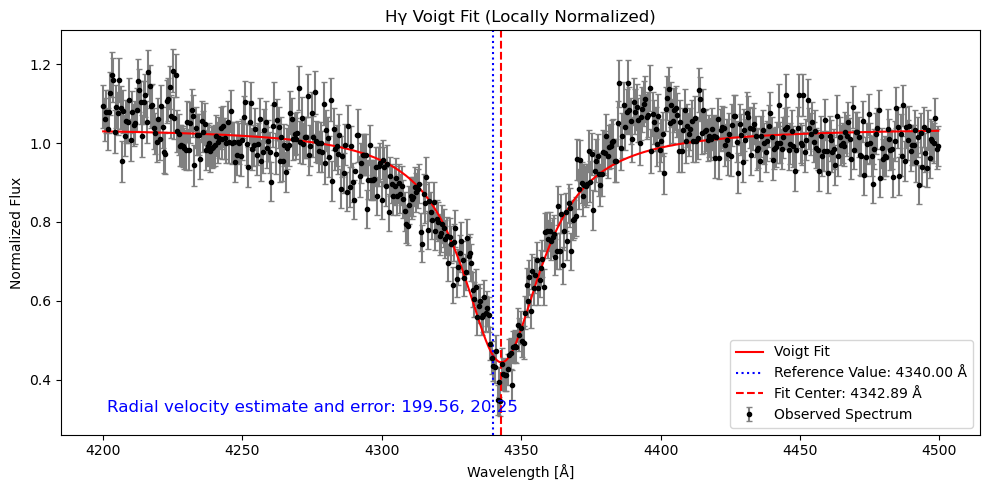

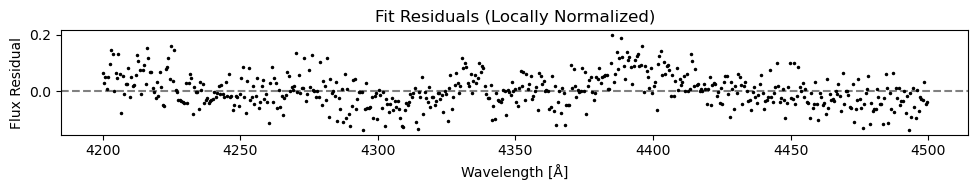

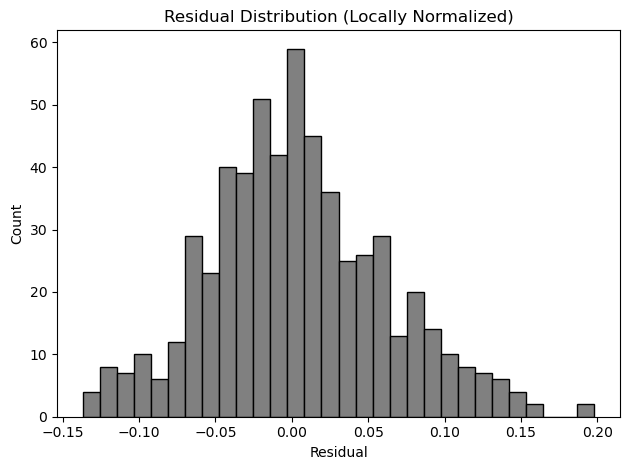

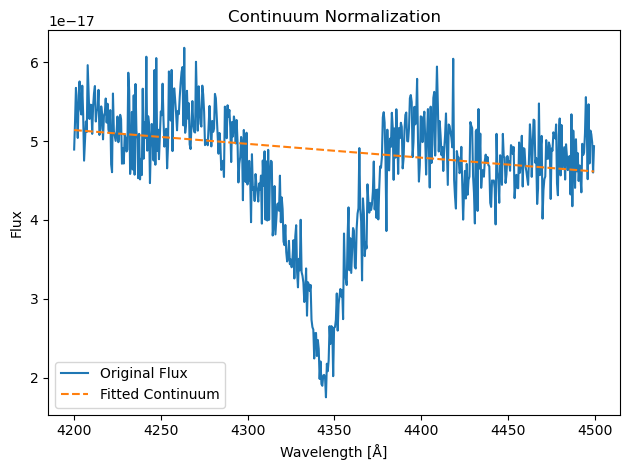

Median of normalized flux in continuum regions: 1.0465
Offset guess (p0[4]) for Voigt fit: 1.0465
Fit center = 4343.0369 ± 0.3639 Å


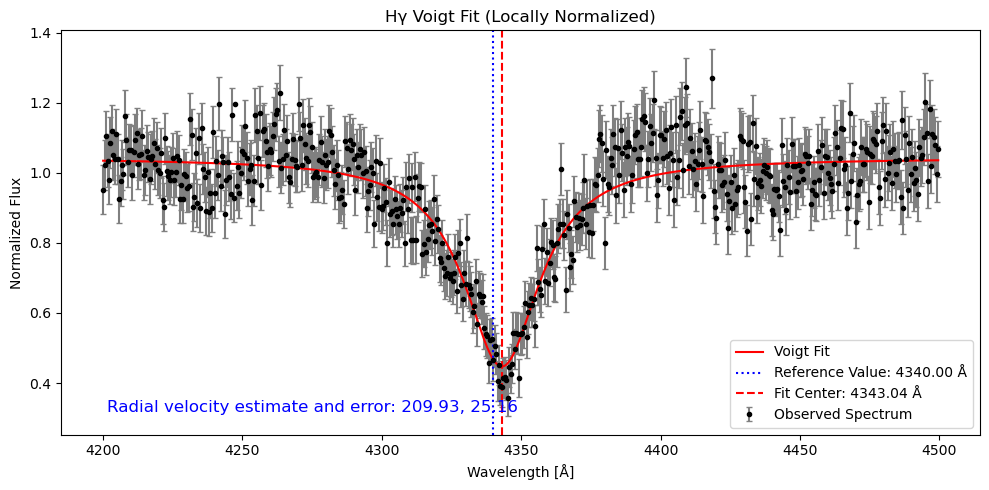

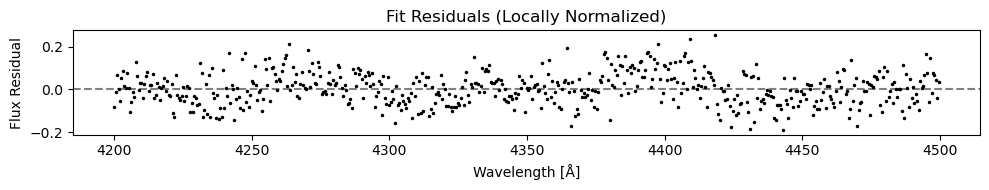

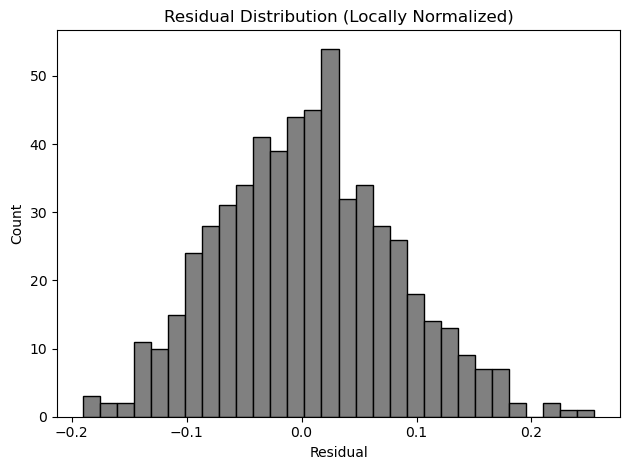

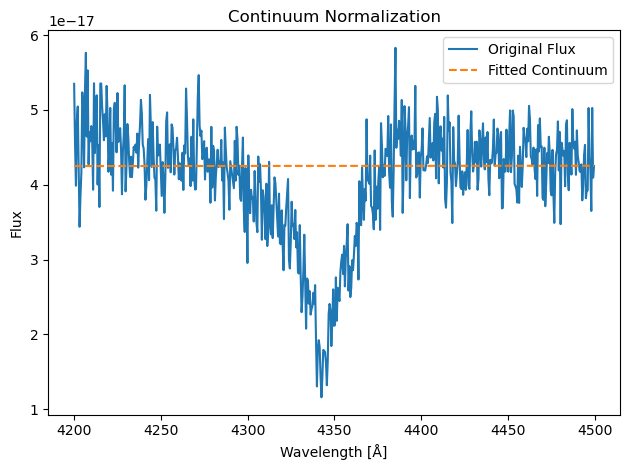

Median of normalized flux in continuum regions: 1.0333
Offset guess (p0[4]) for Voigt fit: 1.0333
Fit center = 4342.9113 ± 0.4484 Å


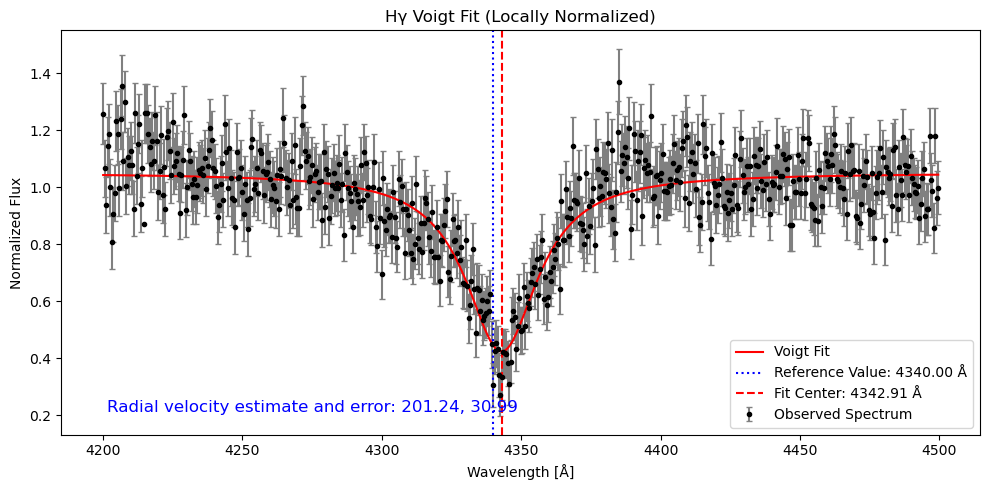

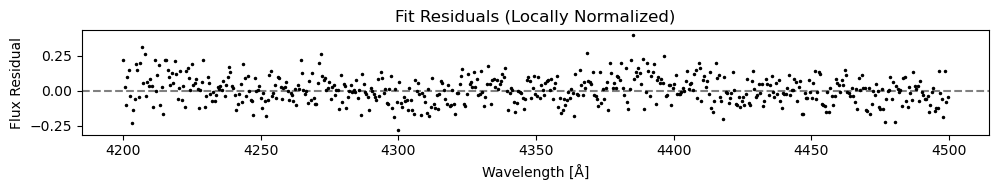

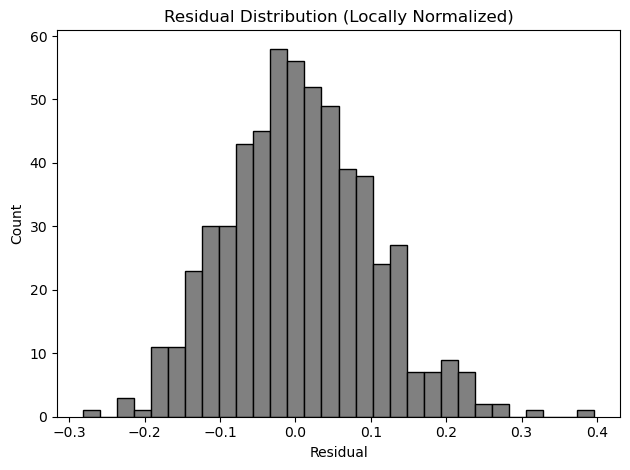

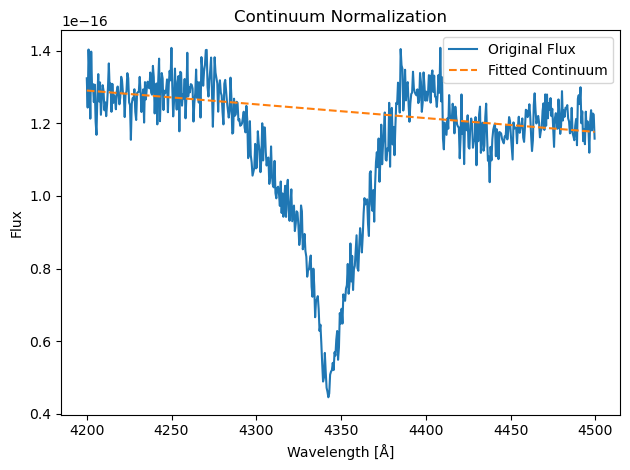

Median of normalized flux in continuum regions: 1.0047
Offset guess (p0[4]) for Voigt fit: 1.0047
Fit center = 4342.7334 ± 0.2464 Å


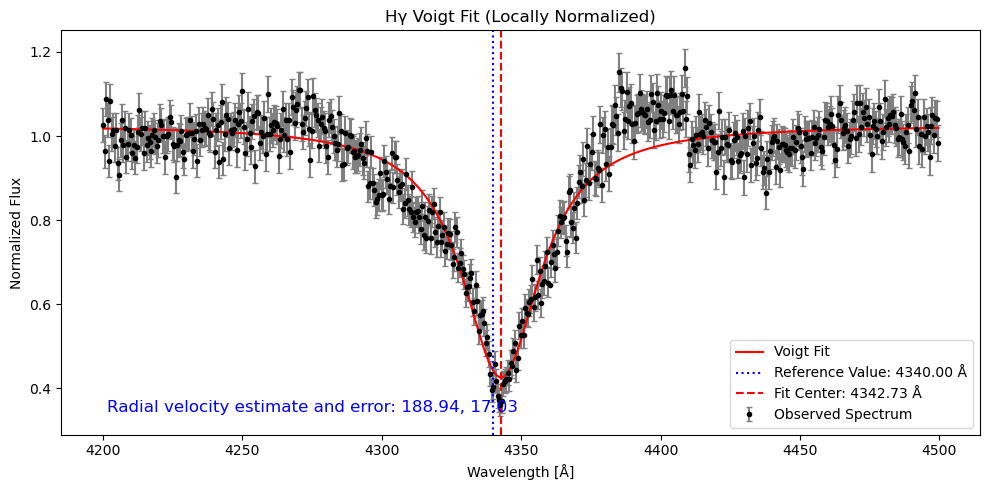

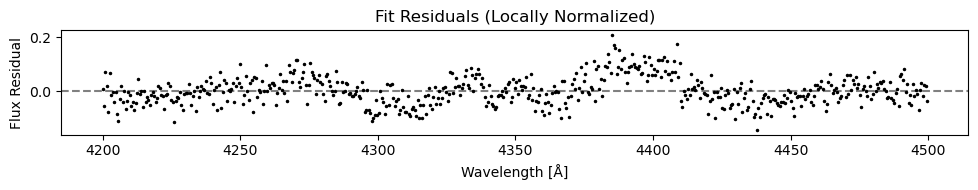

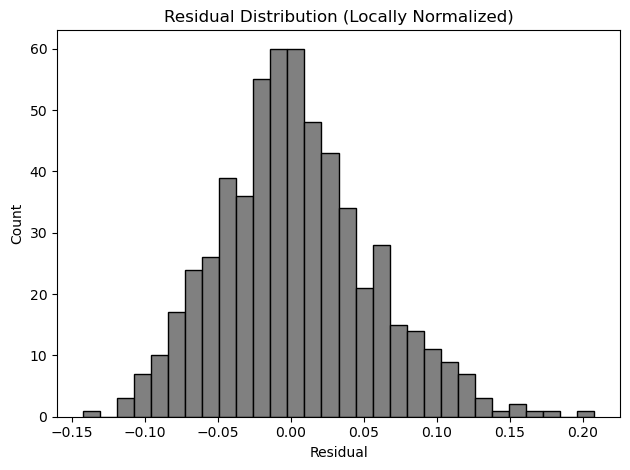

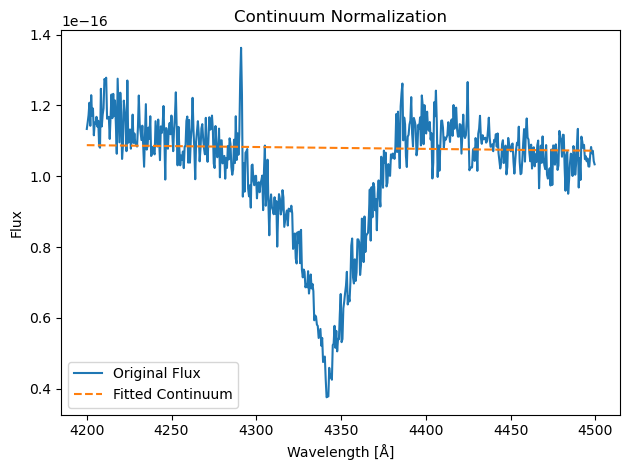

Median of normalized flux in continuum regions: 1.0243
Offset guess (p0[4]) for Voigt fit: 1.0243
Fit center = 4342.2688 ± 0.2846 Å


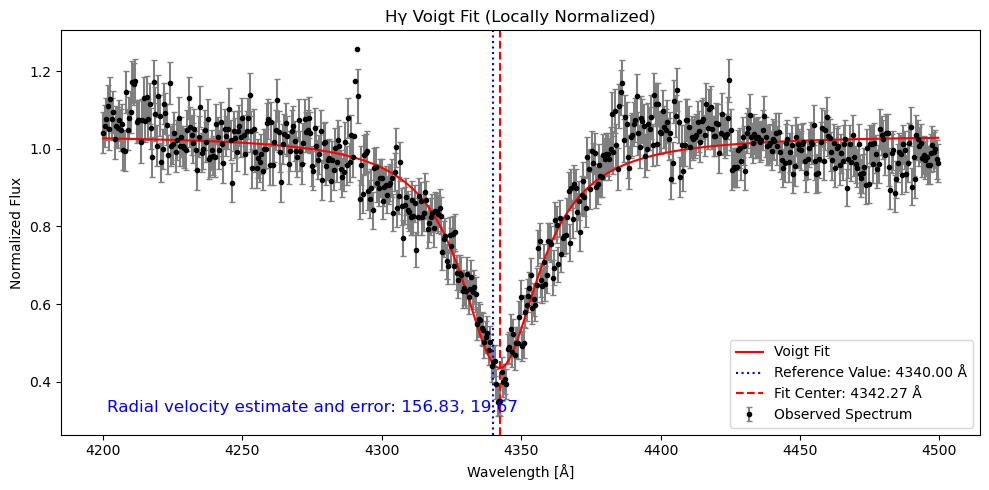

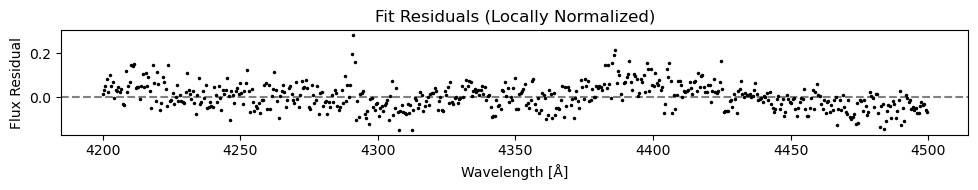

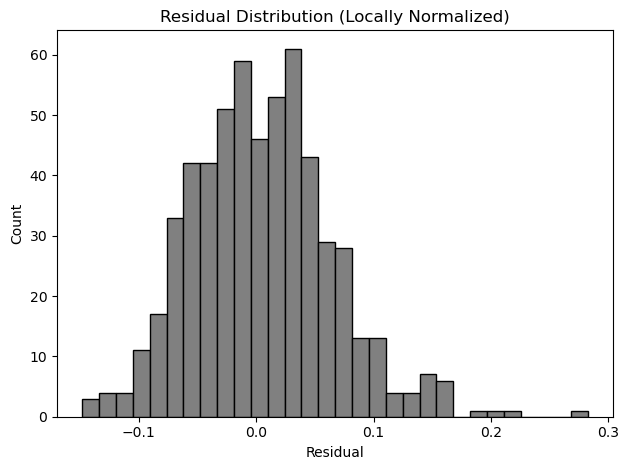

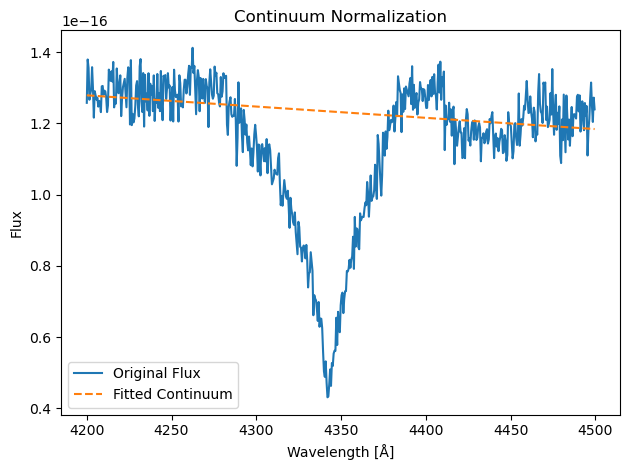

Median of normalized flux in continuum regions: 1.0219
Offset guess (p0[4]) for Voigt fit: 1.0219
Fit center = 4342.1711 ± 0.2389 Å


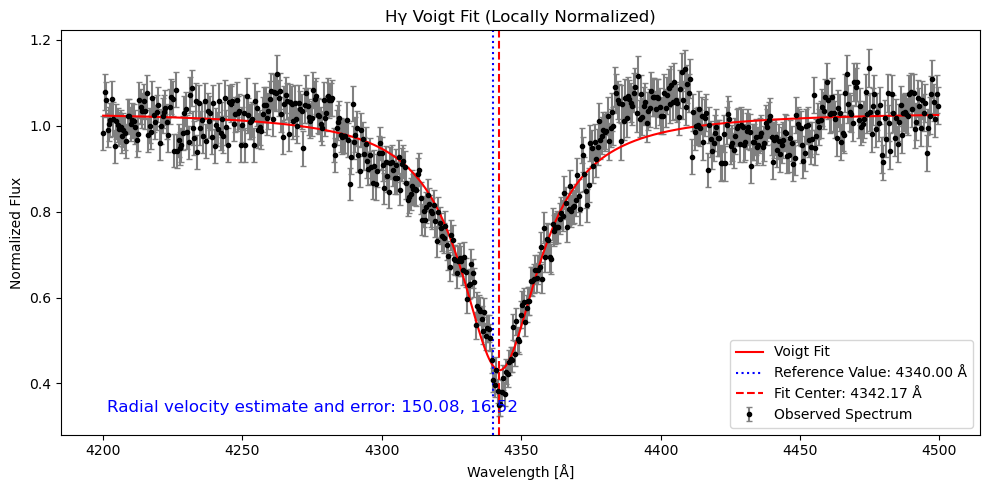

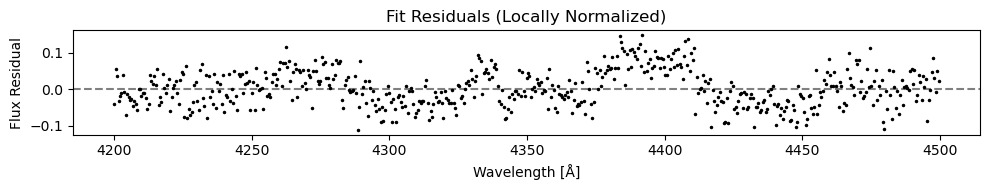

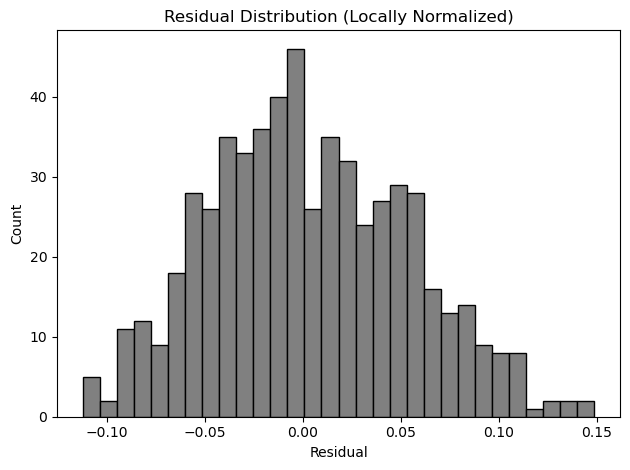

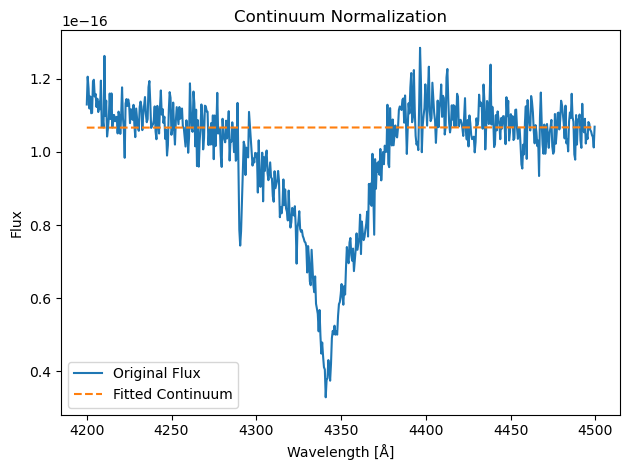

Median of normalized flux in continuum regions: 1.0238
Offset guess (p0[4]) for Voigt fit: 1.0238
Fit center = 4342.2140 ± 0.2626 Å


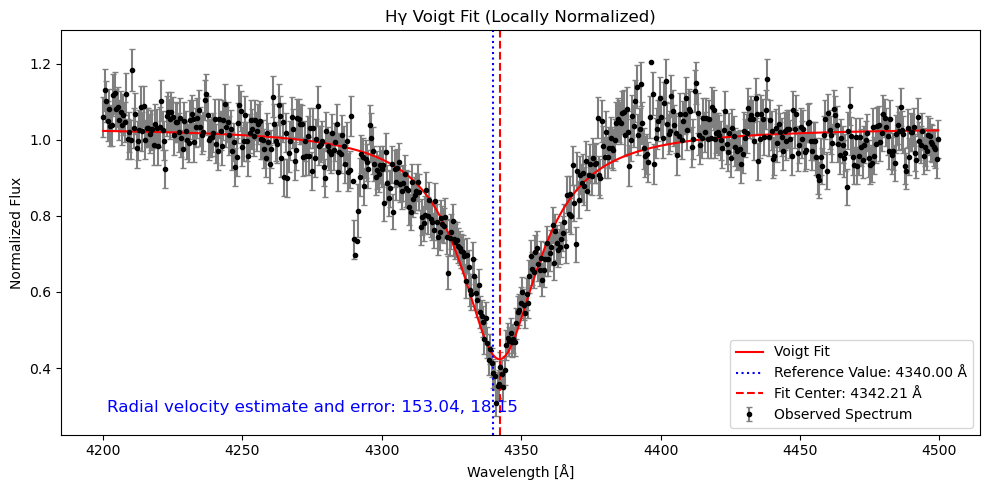

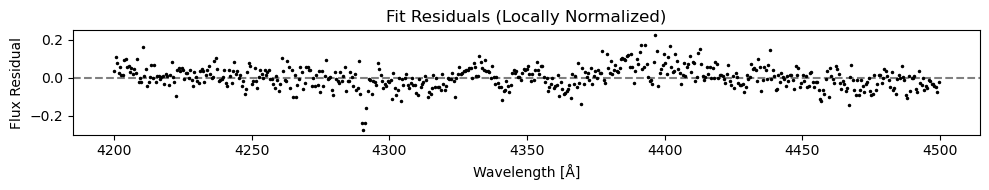

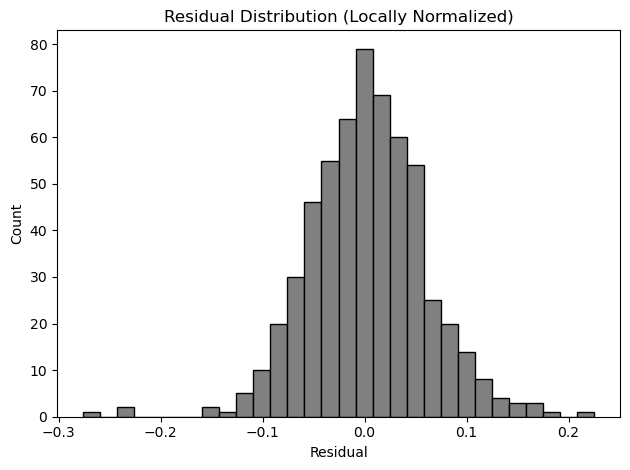

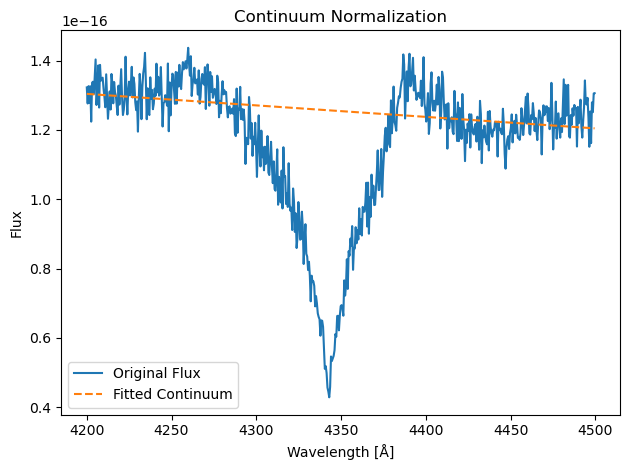

Median of normalized flux in continuum regions: 1.0268
Offset guess (p0[4]) for Voigt fit: 1.0268
Fit center = 4342.4199 ± 0.2398 Å


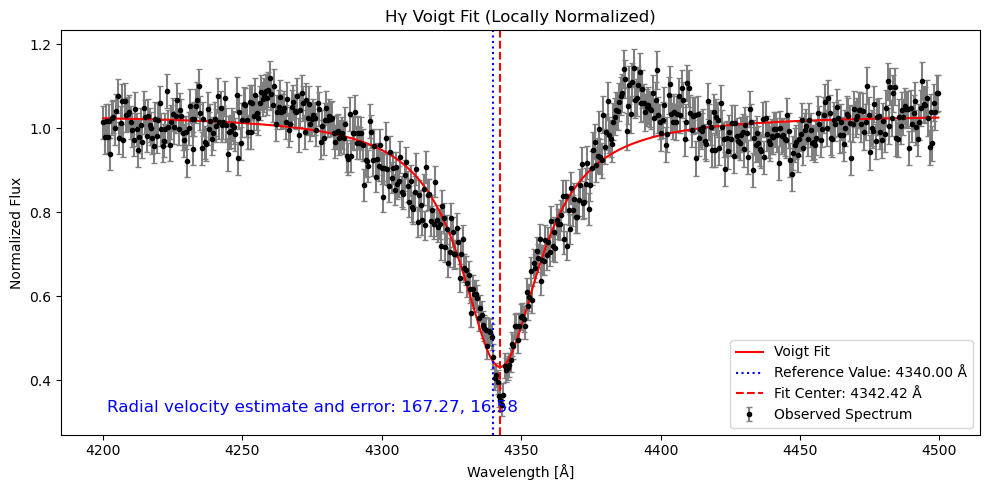

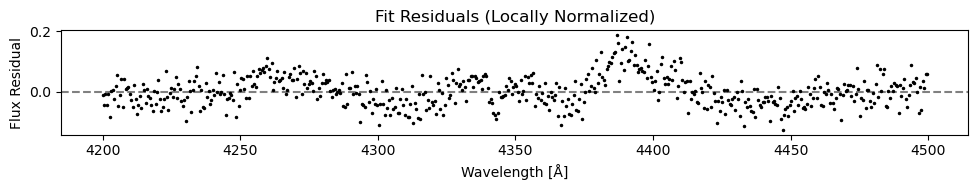

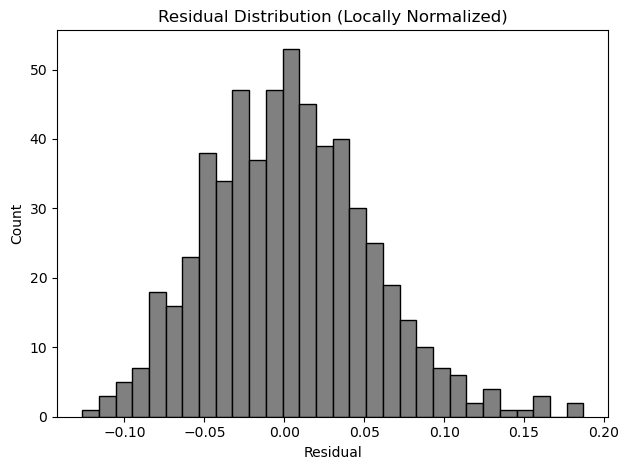

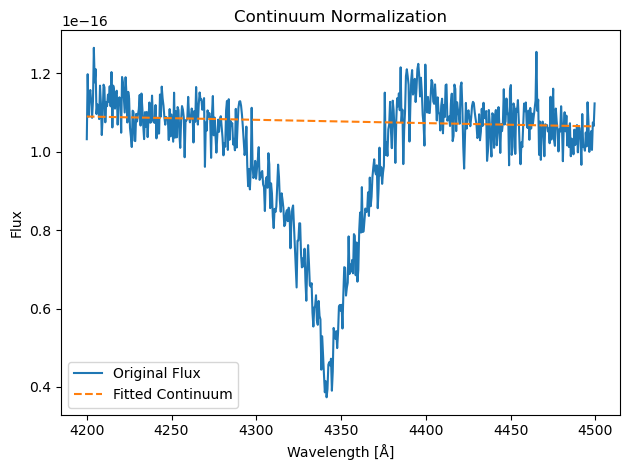

Median of normalized flux in continuum regions: 1.0020
Offset guess (p0[4]) for Voigt fit: 1.0020
Fit center = 4341.3979 ± 0.2887 Å


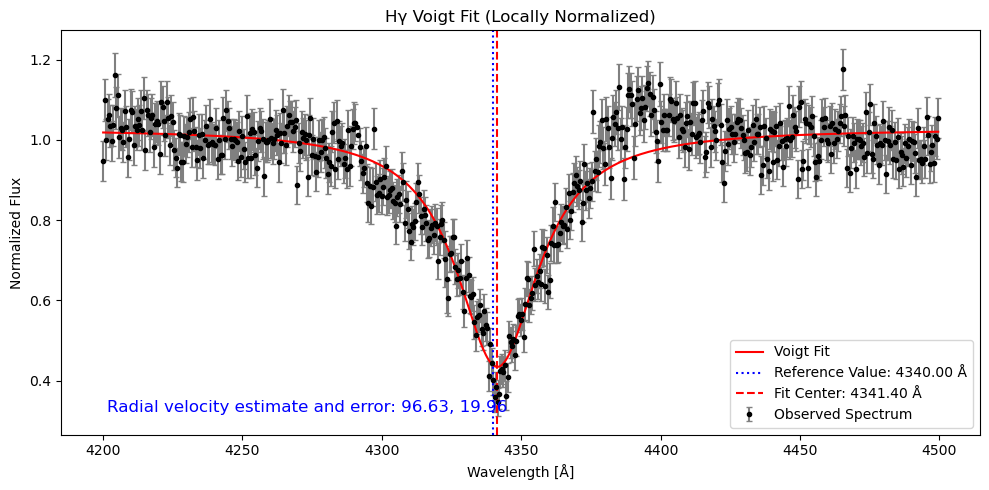

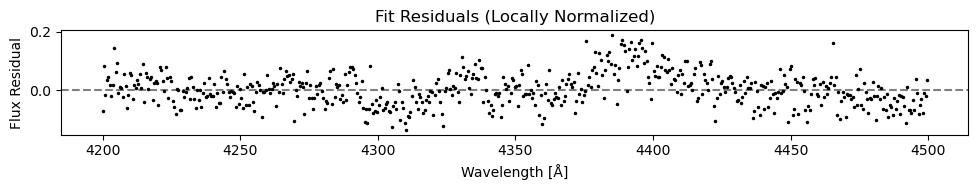

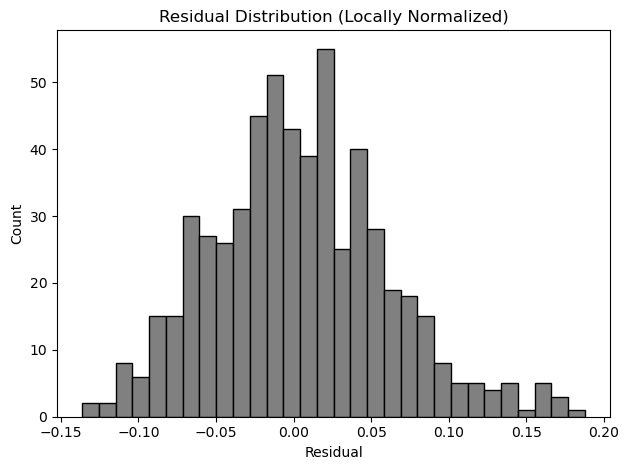

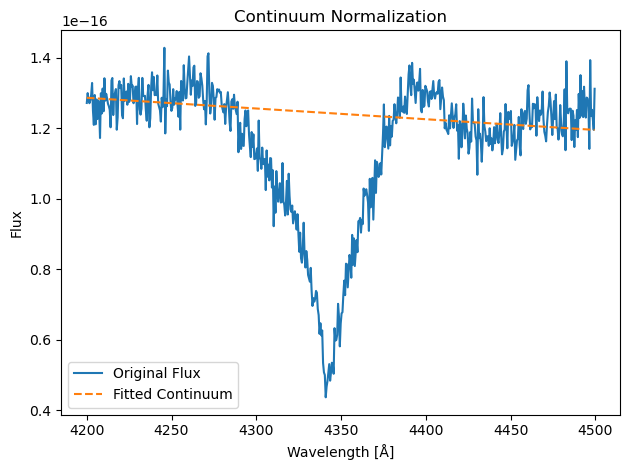

Median of normalized flux in continuum regions: 1.0104
Offset guess (p0[4]) for Voigt fit: 1.0104
Fit center = 4341.9903 ± 0.2367 Å


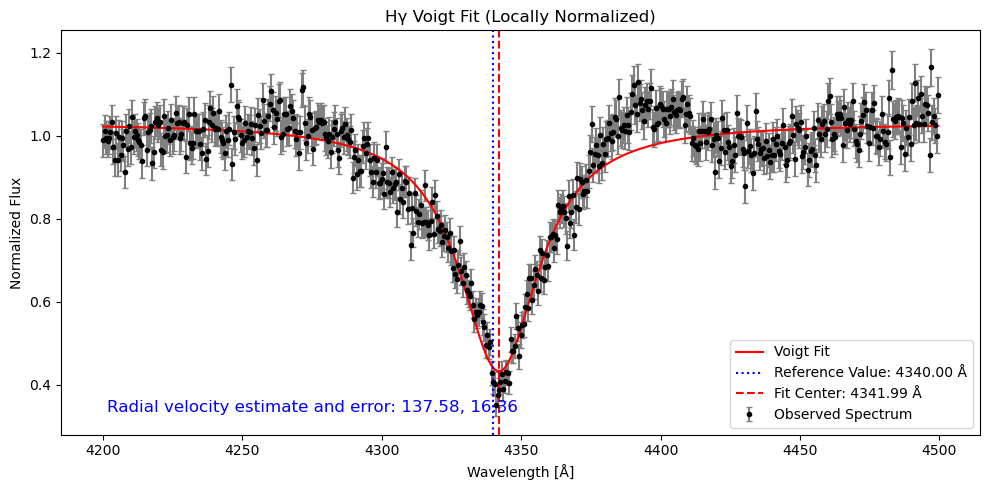

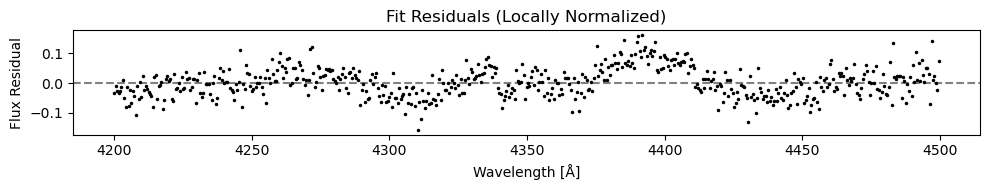

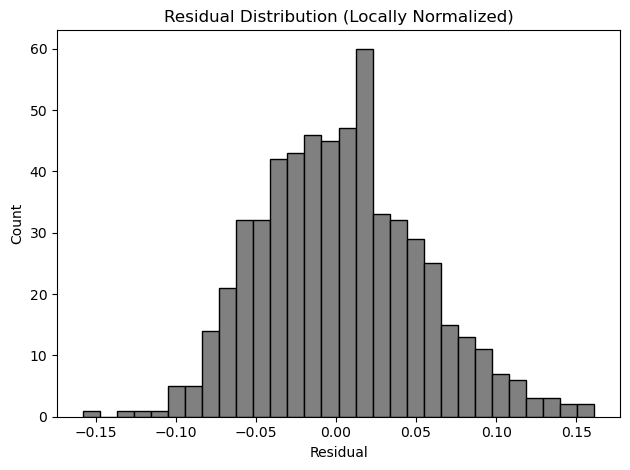

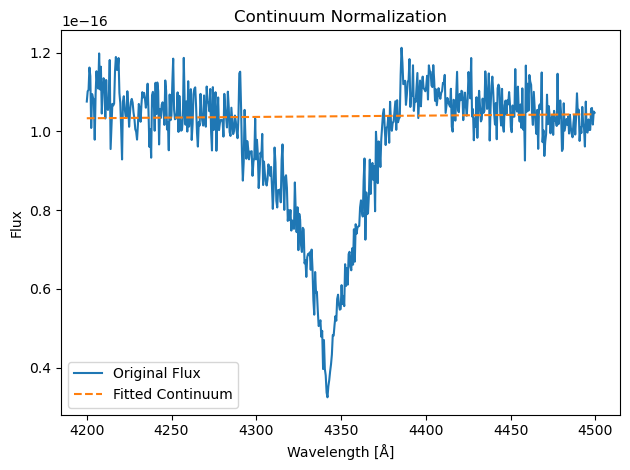

Median of normalized flux in continuum regions: 1.0114
Offset guess (p0[4]) for Voigt fit: 1.0114
Fit center = 4341.8488 ± 0.2731 Å


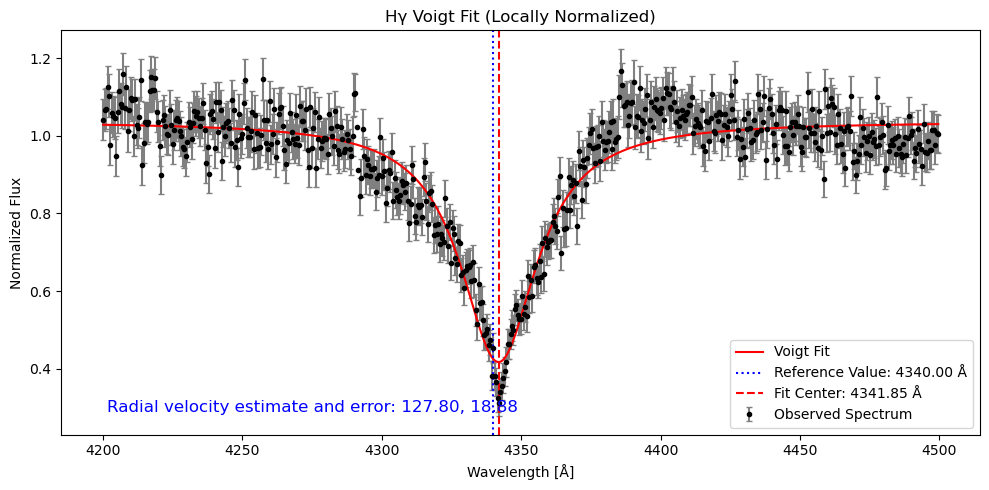

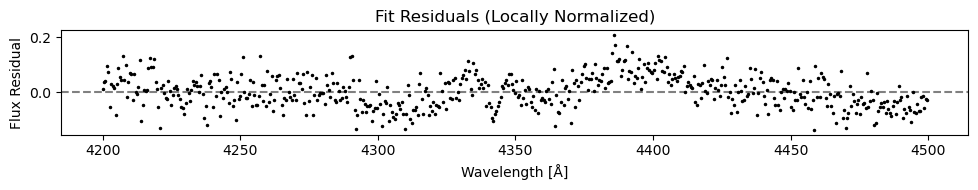

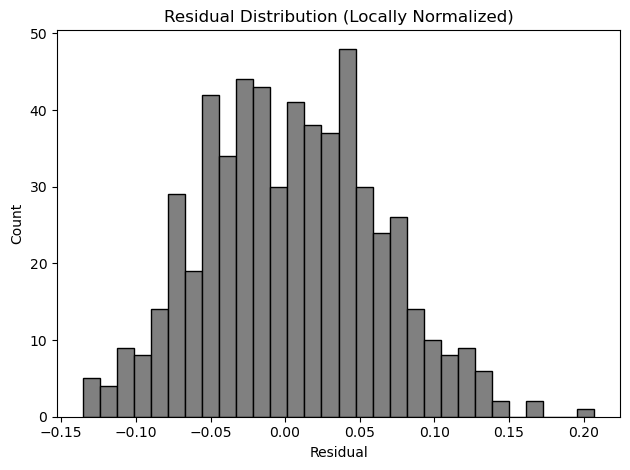

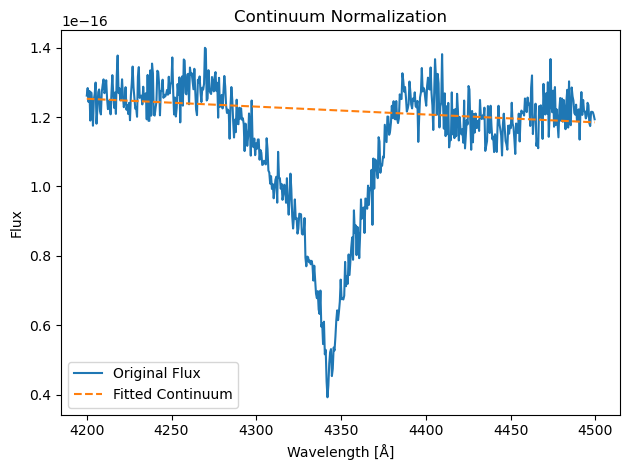

Median of normalized flux in continuum regions: 1.0166
Offset guess (p0[4]) for Voigt fit: 1.0166
Fit center = 4342.5672 ± 0.2425 Å


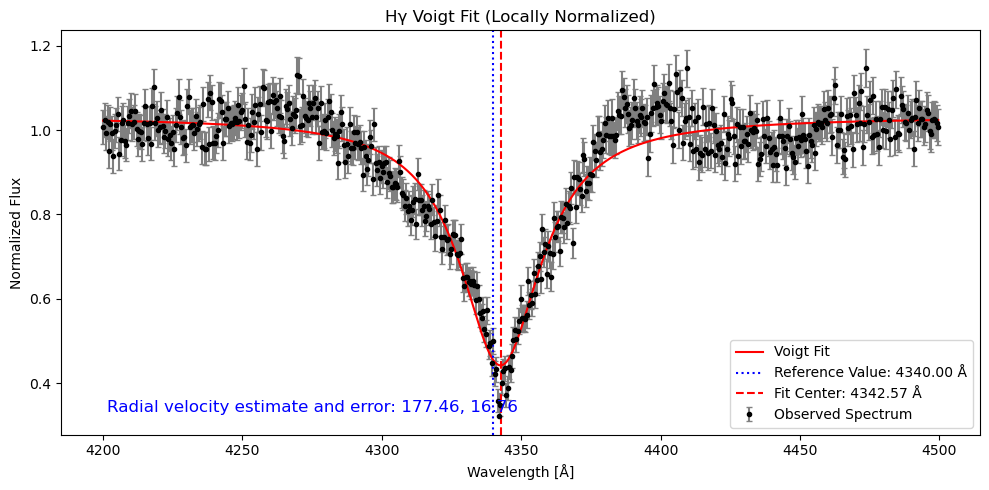

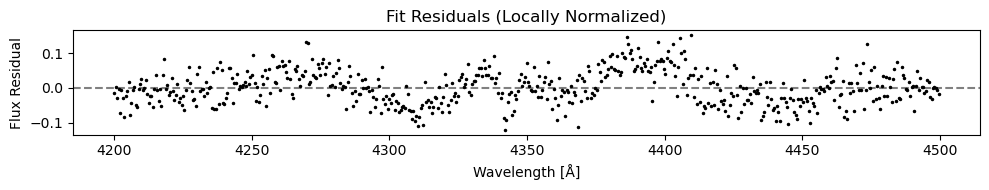

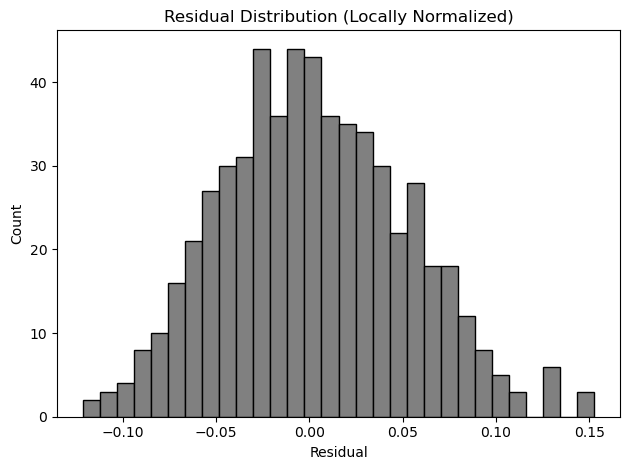

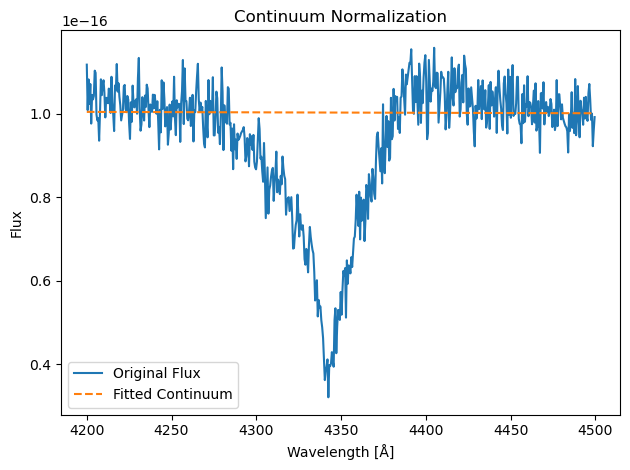

Median of normalized flux in continuum regions: 1.0192
Offset guess (p0[4]) for Voigt fit: 1.0192
Fit center = 4342.3898 ± 0.2853 Å


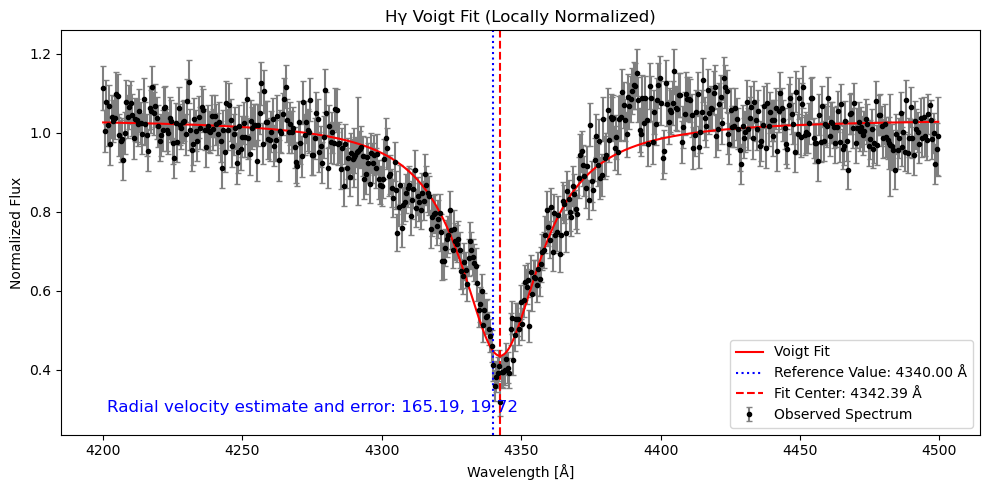

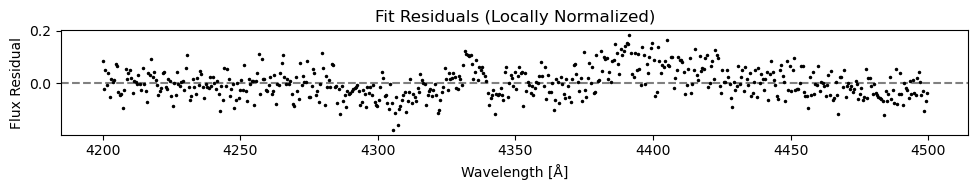

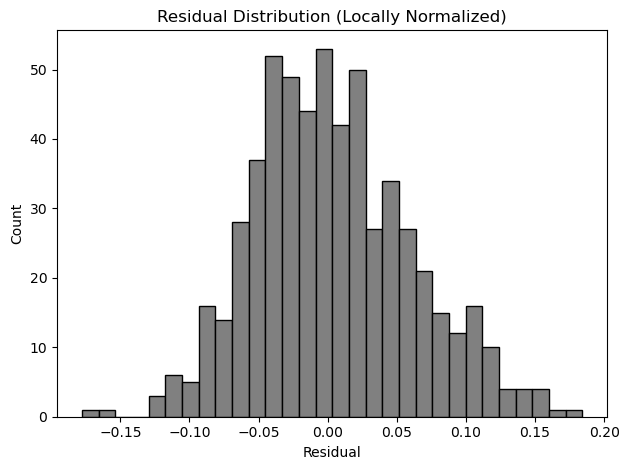

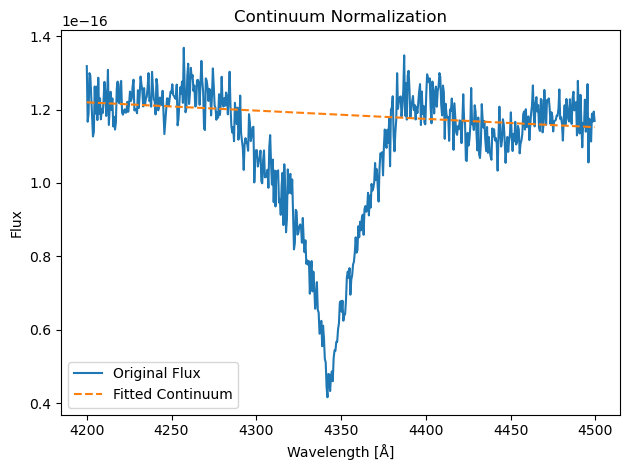

Median of normalized flux in continuum regions: 1.0104
Offset guess (p0[4]) for Voigt fit: 1.0104
Fit center = 4342.9241 ± 0.2374 Å


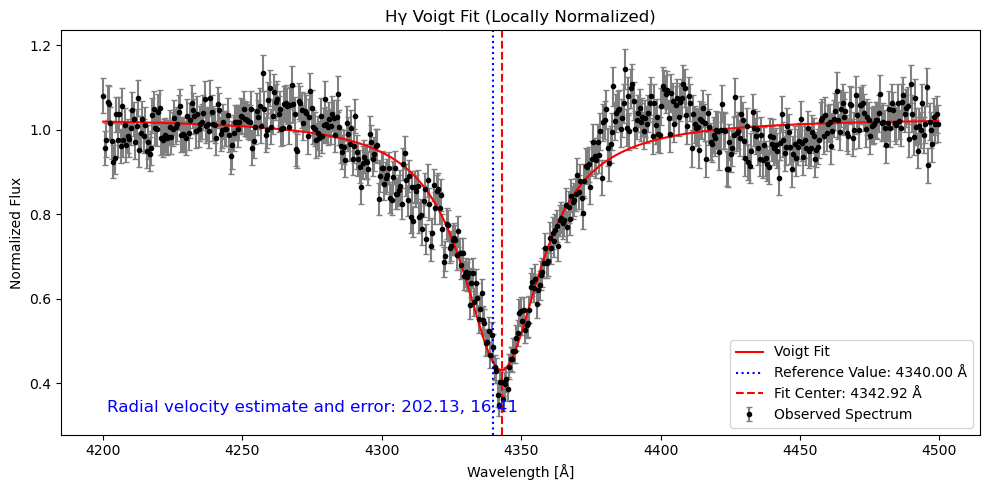

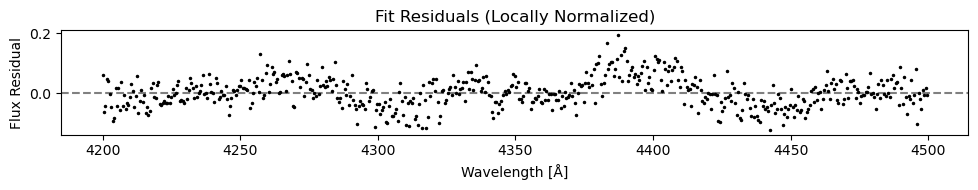

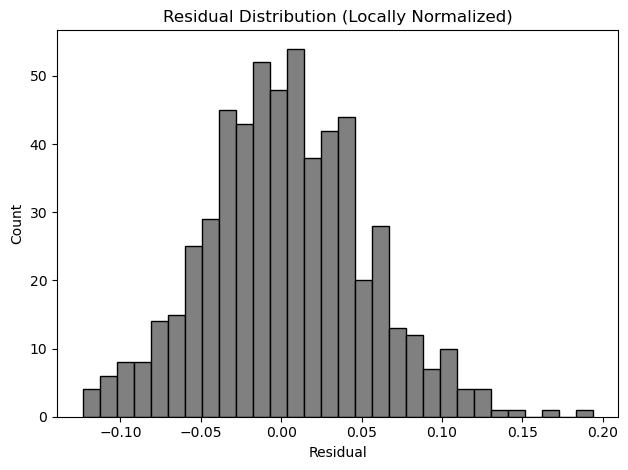

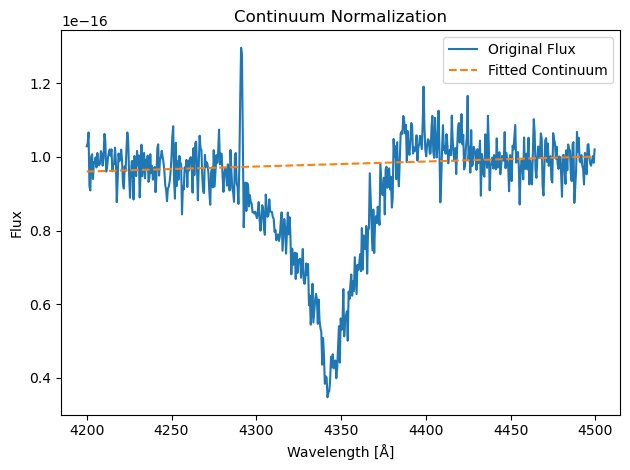

Median of normalized flux in continuum regions: 1.0168
Offset guess (p0[4]) for Voigt fit: 1.0168
Fit center = 4342.8793 ± 0.2992 Å


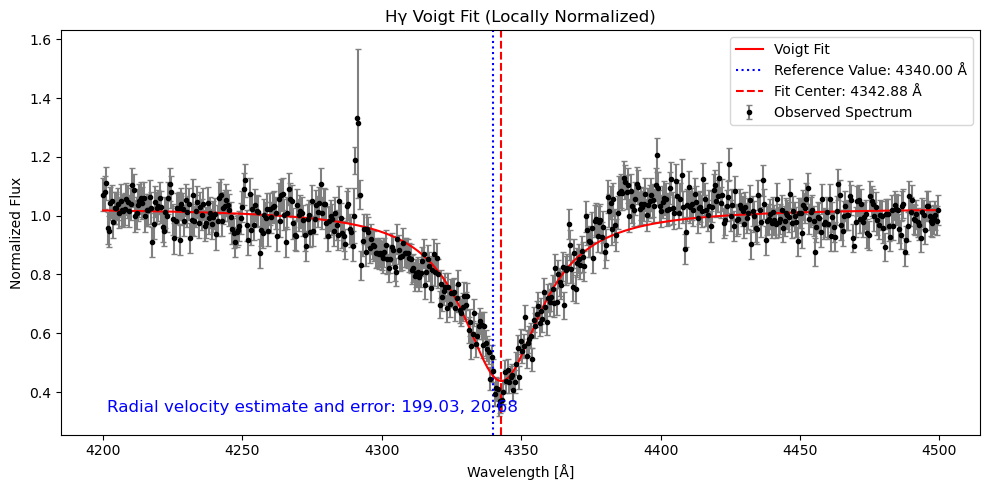

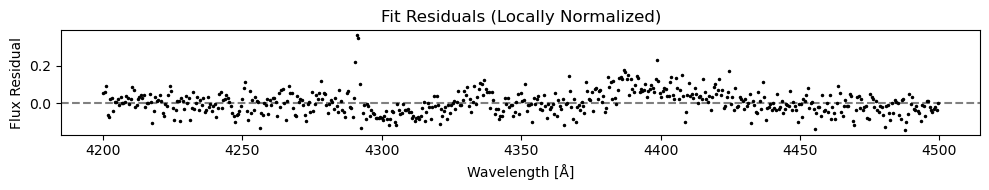

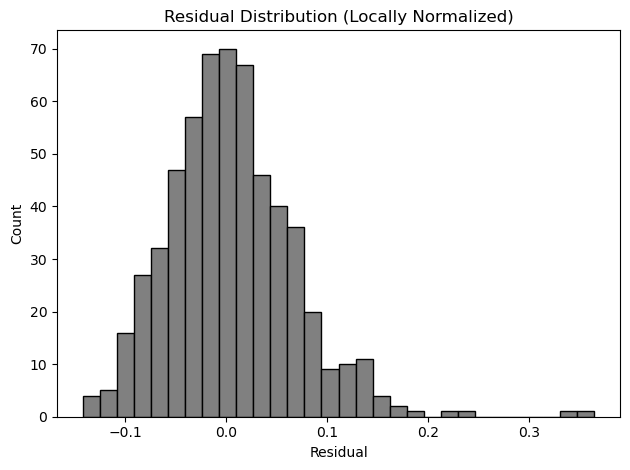

In [ ]:
### ARRAY FN ###
ds = xr.open_dataset("D:/Pavlicek, Emma/WD1202/WD1202_spectra.nc", engine="h5netcdf")
wavelength = ds['wavelength'].values
flux_array = ds['flux_calibrated'].values  # shape: (time, wavelength)

centroids = []
velocities = []
centroid_errors = []
velocity_errors = []

for i in range(flux_array.shape[0]):
    flux = flux_array[i, :]
    flux_err = ds['flux_calibrated_error'].values[i, :]
    
    # Set plot=True every n indices
    should_plot = (i % 1 == 0)
    center, center_err, velocity, velocity_err = fit_centroid(
        wavelength, flux, flux_error=flux_err, lambda_0=4340, w1=4200, w2=4500, line_name="Hγ", plot=should_plot
        )
    
    centroids.append(center)
    centroid_errors.append(center_err)
    velocity_errors.append(velocity_err)
    velocities.append(velocity)



# Convert to xarrays
vel_da = xr.DataArray(
    data=velocities,
    coords={"time": ds.time},
    dims=["time"],
    name="radial_velocity",
    attrs={"units": "km/s", "description": "Radial velocity from Hα centroid"}
)

center_da = xr.DataArray(
    data=centroids,
    coords={"time": ds.time},
    dims=["time"],
    name="centroid",
    attrs={"units": "Angstrom", "description": "Fitted centroid of Hα absorption"}
)

centroid_err_da = xr.DataArray(
    data=centroid_errors,
    coords={"time": ds.time},
    dims=["time"],
    name="centroid_error",
    attrs={"units": "Angstrom", "description": "Uncertainty in fitted Hα centroid"}
)

vel_err_da = xr.DataArray(
    data=velocity_errors,
    coords={"time": ds.time},
    dims=["time"],
    name="radial_velocity_error",
    attrs={"units": "km/s", "description": "Uncertainty in radial velocity from Hα centroid"}
)

fit_result_ds = xr.Dataset({
    "radial_velocity": vel_da,
    "radial_velocity_error": vel_err_da,
    "centroid": center_da,
    "centroid_error": centroid_err_da
})



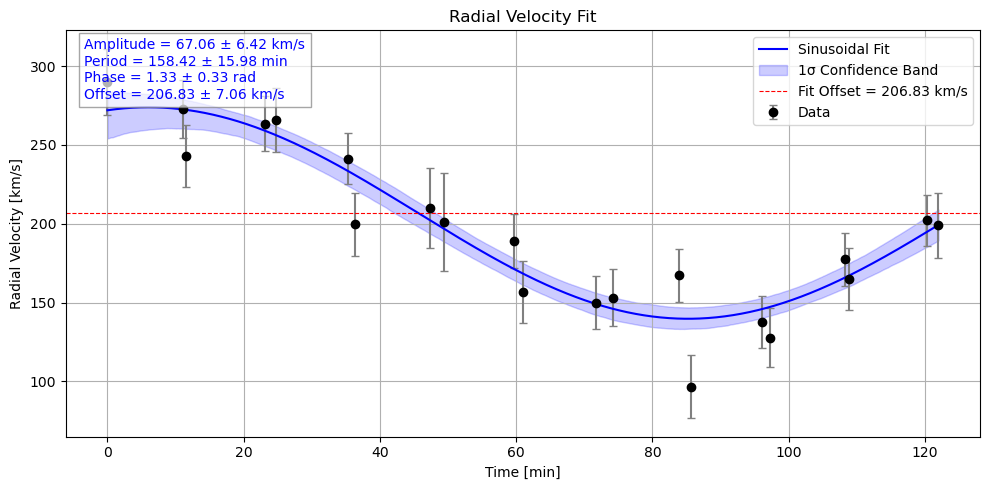

Amplitude = 67.06 ± 6.42 km/s
Frequency = 0.00631 ± 0.00064 cycles/min
Period = 158.42 ± 15.98 min
Phase = 1.33 ± 0.33 rad
Offset = 206.83 ± 7.06 km/s


In [11]:
###FIT LEVEL 2###
# --- Data extraction ---
v = fit_result_ds['radial_velocity'].values
v_err = fit_result_ds['radial_velocity_error'].values
time = fit_result_ds['time'].values

# Remove NaNs
# Remove NaNs
mask = ~np.isnan(v) & ~np.isnan(v_err) & ~np.isnan(time)
time = time[mask]
v = v[mask]
v_err = v_err[mask]

# Convert time to minutes since first observation
time0 = time[0]
time = (time - time0) / np.timedelta64(1, 'm')  # now in minutes

# Define sinusoid model: v(t) = A * sin(2π f t + phi) + C
def sinusoid(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Initial guess
A_guess = (np.nanmax(v) - np.nanmin(v)) / 2
f_guess = 1 / (time.max() - time.min())  # one full cycle
phi_guess = 0
C_guess = np.mean(v)

p0 = [A_guess, f_guess, phi_guess, C_guess]

# Fit to raw velocities
popt, pcov = curve_fit(sinusoid, time, v, sigma=v_err, absolute_sigma=True, p0=p0)
A_fit, f_fit, phi_fit, C_fit = popt
perr = np.sqrt(np.diag(pcov))
A_err, f_err, phi_err, C_err = perr

# Compute best-fit curve
time_fit = np.linspace(time.min(), time.max(), 1000)
v_fit = sinusoid(time_fit, *popt)

# Monte Carlo uncertainty band
n_samples = 1000
samples = np.random.multivariate_normal(popt, pcov, size=n_samples)
v_samples = np.array([sinusoid(time_fit, *s) for s in samples])
v_lower = np.percentile(v_samples, 16, axis=0)
v_upper = np.percentile(v_samples, 84, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(time, v, yerr=v_err, fmt='o', color='black', ecolor='gray', capsize=3, label='Data')
plt.plot(time_fit, v_fit, color='blue', label='Sinusoidal Fit')
plt.fill_between(time_fit, v_lower, v_upper, color='blue', alpha=0.2, label='1σ Confidence Band')
plt.title("Radial Velocity Fit")
plt.xlabel("Time [min]")
plt.ylabel("Radial Velocity [km/s]")
plt.axhline(C_fit, color='red', linestyle='--', linewidth=0.8, label=f'Fit Offset = {C_fit:.2f} km/s')
plt.legend()
plt.grid(True)

# Add fit parameters to plot
fit_label = (
    f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s\n"
    f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min\n"
    f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad\n"
    f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s"
)
plt.text(0.02, 0.98, fit_label, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', color='blue',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()
# --- Print fitted parameters ---
print(f"Amplitude = {A_fit:.2f} ± {A_err:.2f} km/s")
print(f"Frequency = {f_fit:.5f} ± {f_err:.5f} cycles/min")
print(f"Period = {1/f_fit:.2f} ± {(f_err / f_fit**2):.2f} min")
print(f"Phase = {phi_fit:.2f} ± {phi_err:.2f} rad")
print(f"Offset = {C_fit:.2f} ± {C_err:.2f} km/s")
